# 算符扩散

## 概述

在本教程中，我们将介绍作为混沌动力学和信息加扰诊断的算子扩散。我们将检查算子扩散作为电路深度 $L$ 的函数，可以将其视为离散量子系统中的时间 $t$。 此处考虑的算子扩散系数为：
$$
C_{y}(j,t)=\frac{1}{2} \text{Tr}([O(t), \sigma^{(j)}_{y}]^{\dagger}[O(t),\sigma^{(j)}_{y}]),
$$
其中 $\sigma_{y}^{(j)}$ 是第 $j$ 个量子位的 Pauli-y 矩阵。 $O(0)$ 是位于 $N/2$ 的 Pauli-x 矩阵，即 $\sigma_{x}^{(N/2)}$。 并且$O(t)=U(t)^{\dagger}O(0)U(t)$，其中$U(t)$是具有$t$层的电路的幺正矩阵。

算子传播的一个物理图像是，如果海森堡算子增长$O(t)$没有到达站点$j$，$[O(t), \sigma_{y}^{(j)}]=0 $，而当站点 $N/2, j$ 在因果区域内变得相关时，等式将被打破。

## 设置

In [1]:
import numpy as np
import tensorflow as tf
import tensorcircuit as tc
import matplotlib.pyplot as plt

tc.set_backend("tensorflow")
tc.set_dtype("complex128")
dtype = np.complex128

### 参数

In [2]:
N = 6  # 量子比特的的个数
L = 2  # 量子电路的层数
num_trial = 1  # 随机电路实例数

### 量子电路的幺正矩阵$U(t)$

电路架构如下所示，每个模块包括两个沿 y 轴 ($R_{y}$) 的 Pauli 旋转门，然后是 $CZ$ 门。 我们可以通过将输入状态设置为单位矩阵来得到电路的幺正矩阵$U(t)$。

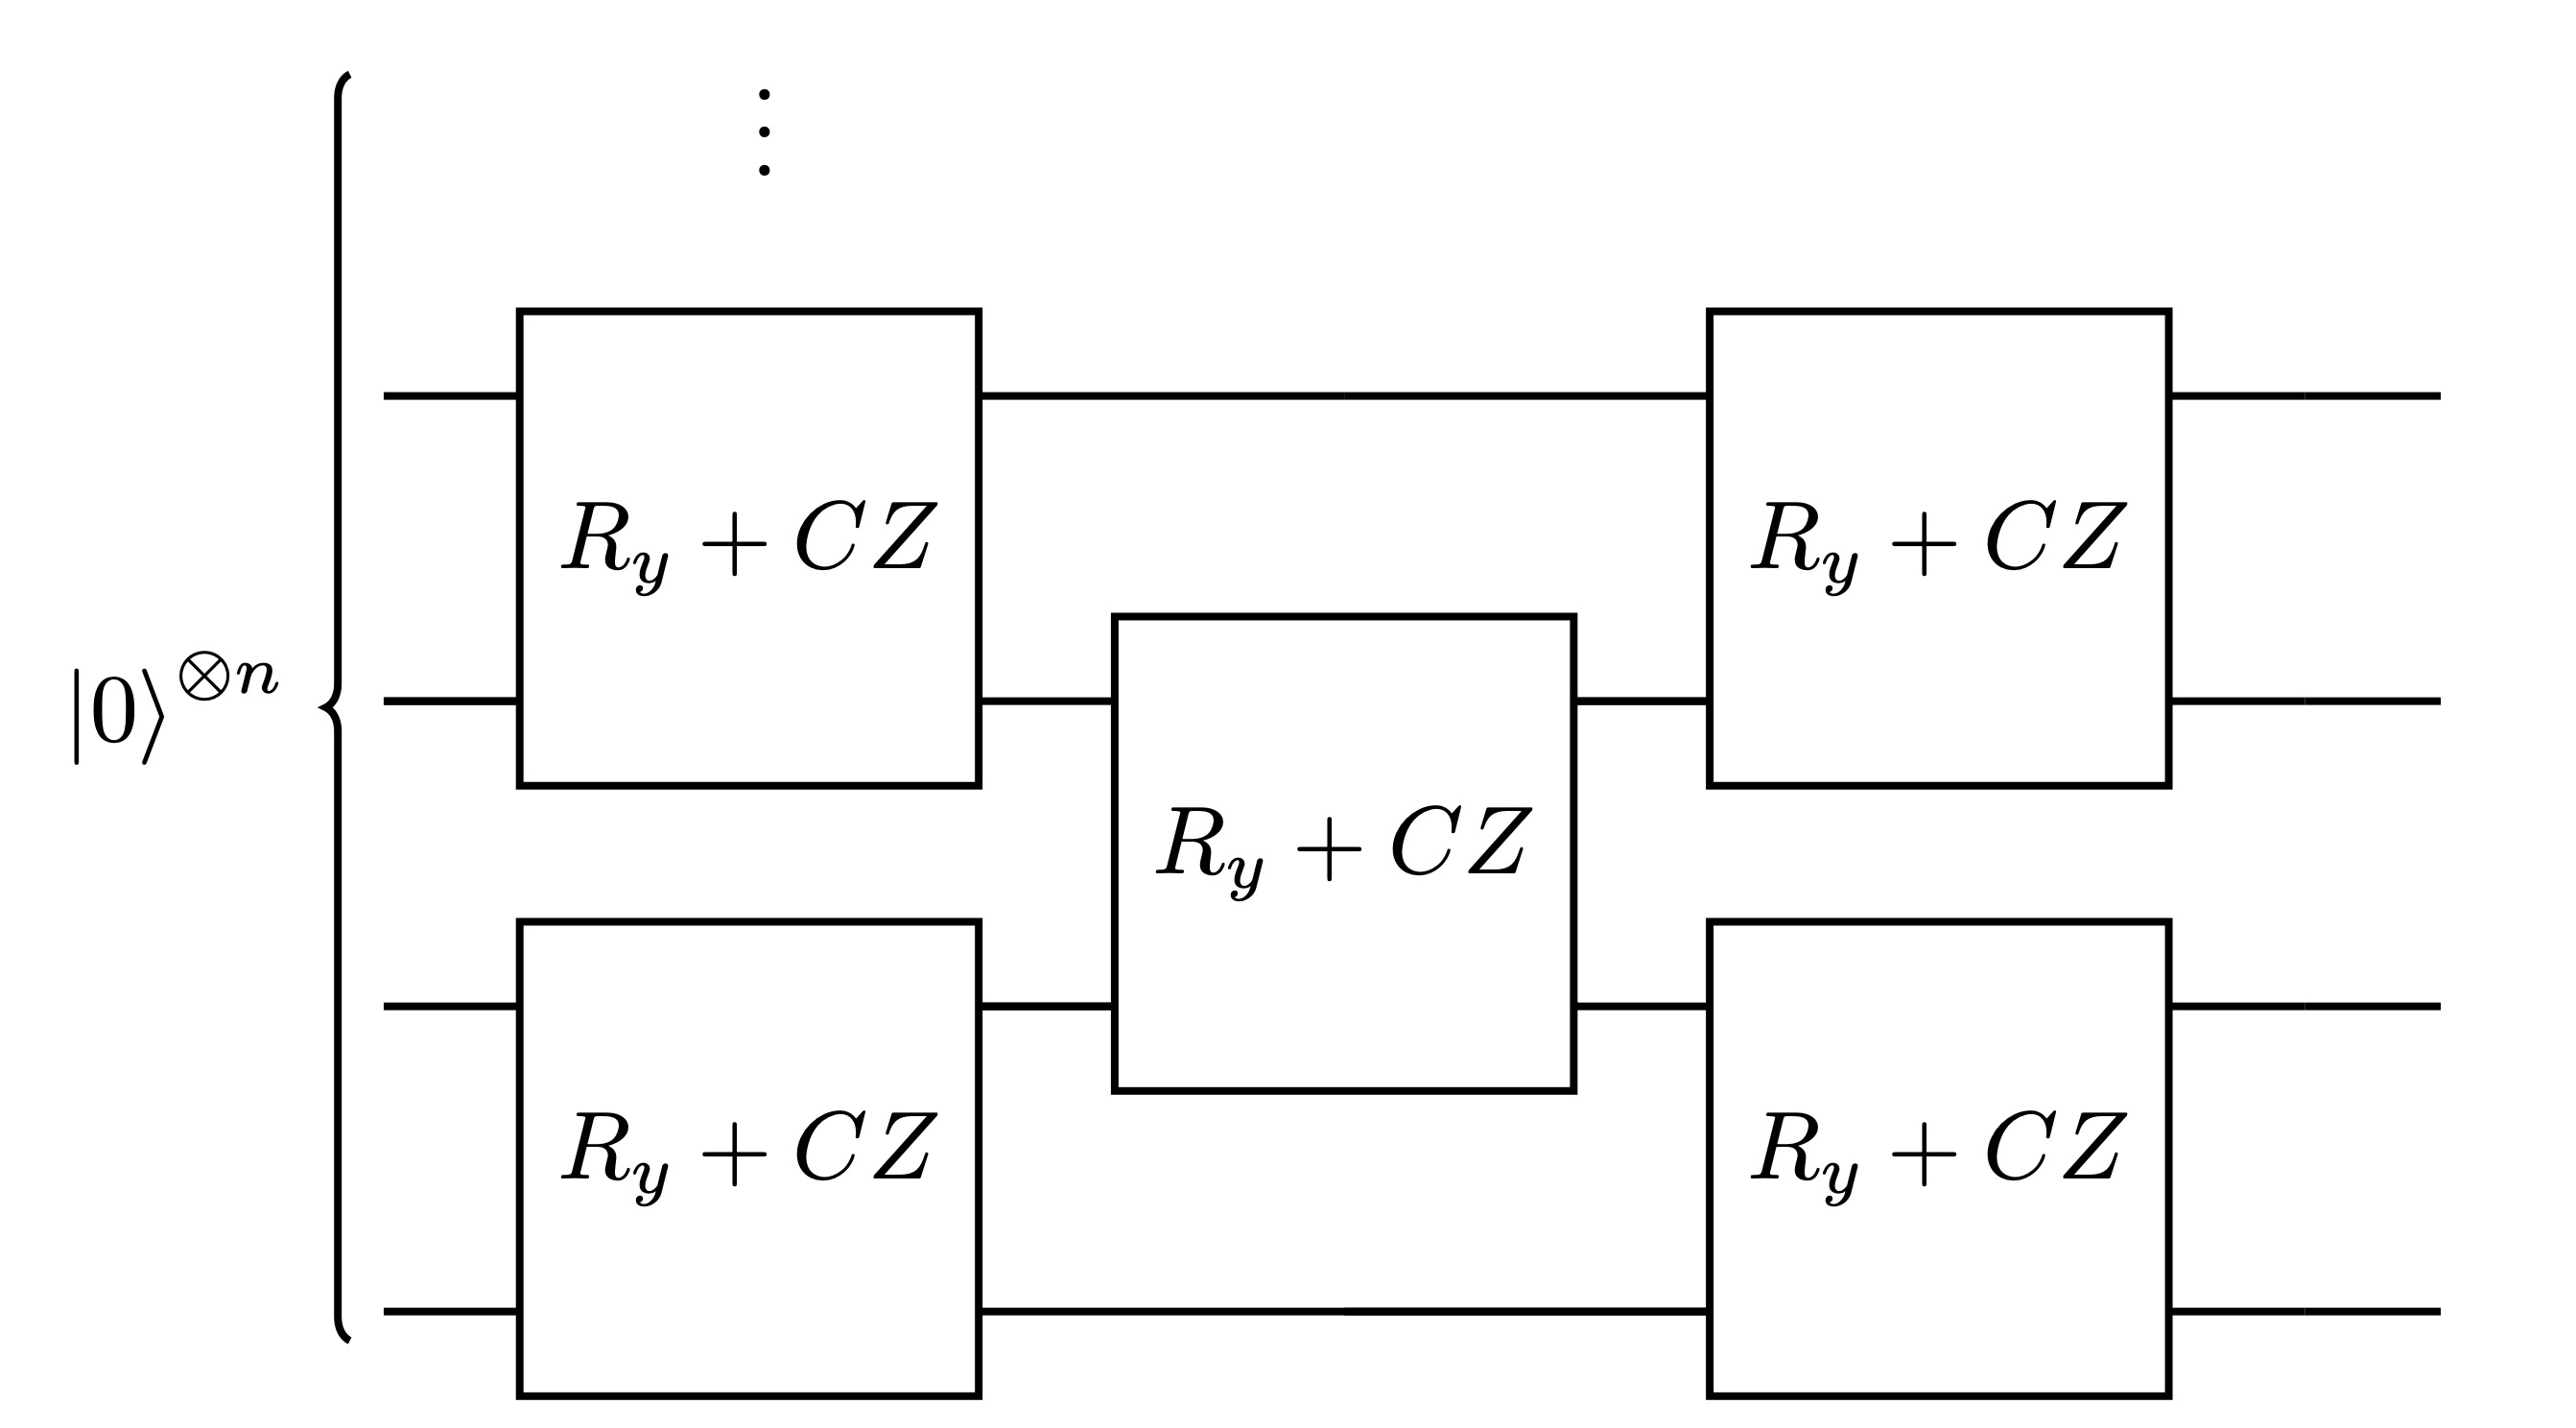

In [3]:
@tf.function()
def get_unitary_of_circuit(v):
    layers = len(v)
    c = tc.Circuit(
        N, inputs=np.eye(2**N, dtype=dtype)
    )  # 当我们选择inputs=np.eye(2**N,...)时，输出波函数
    # 是量子电路的幺正矩阵 U(t)

    # Ry+Cz
    for layer in range(layers):
        if layer % 2 == 0:
            for i in range(0, N, 2):
                c.ry(i, theta=v[layer, i])
                c.ry(i + 1, theta=v[layer, i + 1])
                c.cz(i, i + 1)
        else:
            for i in range(1, N, 2):
                c.ry(i, theta=v[layer, i])
                c.ry((i + 1) % N, theta=v[layer, (i + 1) % N])
                c.cz(i, (i + 1) % N)
    U = c.wavefunction()  # 波函数的输出是一个向量，它的 dim=2^(2N)
    U = tf.reshape(U, [2**N, 2**N])  # 将向量重塑为矩阵
    return U

### $t=0$ 时的运算符

In [4]:
# j 表示算子位于第 j 个量子位
# a 表示算子的类型，a=1 (2,3) 是 Pauli-x (y,z) 矩阵
def get_operator(j, a):
    I = tc.gates._i_matrix
    if a == 1:
        σ = tc.gates._x_matrix  # Pauli-x 矩阵
    elif a == 2:
        σ = tc.gates._y_matrix  # Pauli-y 矩阵
    elif a == 3:
        σ = tc.gates._z_matrix  # Pauli-z 矩阵
    h = []
    for i in range(N):
        if i == j:
            h.append(σ)
        else:
            h.append(I)

    # Pauli-a 矩阵位于第 j 个量子位
    operator = h[0]
    for i in range(N - 1):
        operator = np.kron(operator, h[i + 1])
    return tf.cast(operator, dtype=dtype)

### 算子传播

算子传播 $C_{y}(j,t)=\frac{1}{2} \text{Tr}([O(t), \sigma^{(j)}_{y}]^{\ dagger}[O(t),\sigma^{(j)}_{y}])$ 可以写成：
$$
C_{y}(j,t) = 1- \frac{\rm{Re}(\rm{Tr}(\sigma^{(j)}_{y} O(t)^{\dagger} \sigma^{(j)}_{y} O(t)))}{2^N}.
$$

In [5]:
@tf.function()
def get_spreading(v, σ_y):
    U = get_unitary_of_circuit(v)
    U_dagger = tf.transpose(U, conjugate=True)
    σ_x = get_operator(int(N / 2), 1)  # O(0)
    σ_x_t = U_dagger @ σ_x @ U  # O(t)
    σ_x_t_dagger = tf.transpose(σ_x_t, conjugate=True)
    C = tf.linalg.trace(σ_y @ σ_x_t_dagger @ σ_y @ σ_x_t)
    C = 1 - tf.math.real(C) / (2**N)
    return C

In [6]:
def main(layers=1):
    # 使用 vmap 获取不同随机电路实例的算子扩散系数
    # num_trial：随机电路实例的数量
    # layers：电路层数
    get_spreading_vmap = tc.backend.vmap(get_spreading, vectorized_argnums=0)

    C = get_spreading_vmap(
        tf.random.uniform(
            [num_trial, layers, N], minval=0.0, maxval=2 * np.pi, dtype=tf.float64
        ),
        [[get_operator(j, 2) for j in range(N)] for _ in range(num_trial)],
    )

    return tf.reduce_mean(C, 0)[0]  # 在不同的随机电路实例上取平均

Text(0, 0.5, 'Operator spreading')

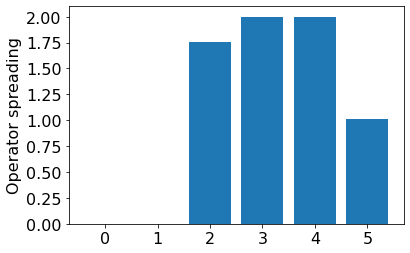

In [7]:
C = main(L)  # 算子在不同随机电路实例上平均分布

plt.bar([i for i in range(N)], C)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel("Operator spreading", fontsize=16)

### 结果

$n = 6$ 量子比特系统的算子扩展为 $1 ≤ j ≤ n = 6$ 的函数，对于不同数量的
层 $L$，平均在 20 个随机电路实例上进行。 当$L=2$时，$O(t)$的海森堡算子增长没有到达$0,1$的站点，$C=0$； 当 $L=10$ 时，等式将被打破。

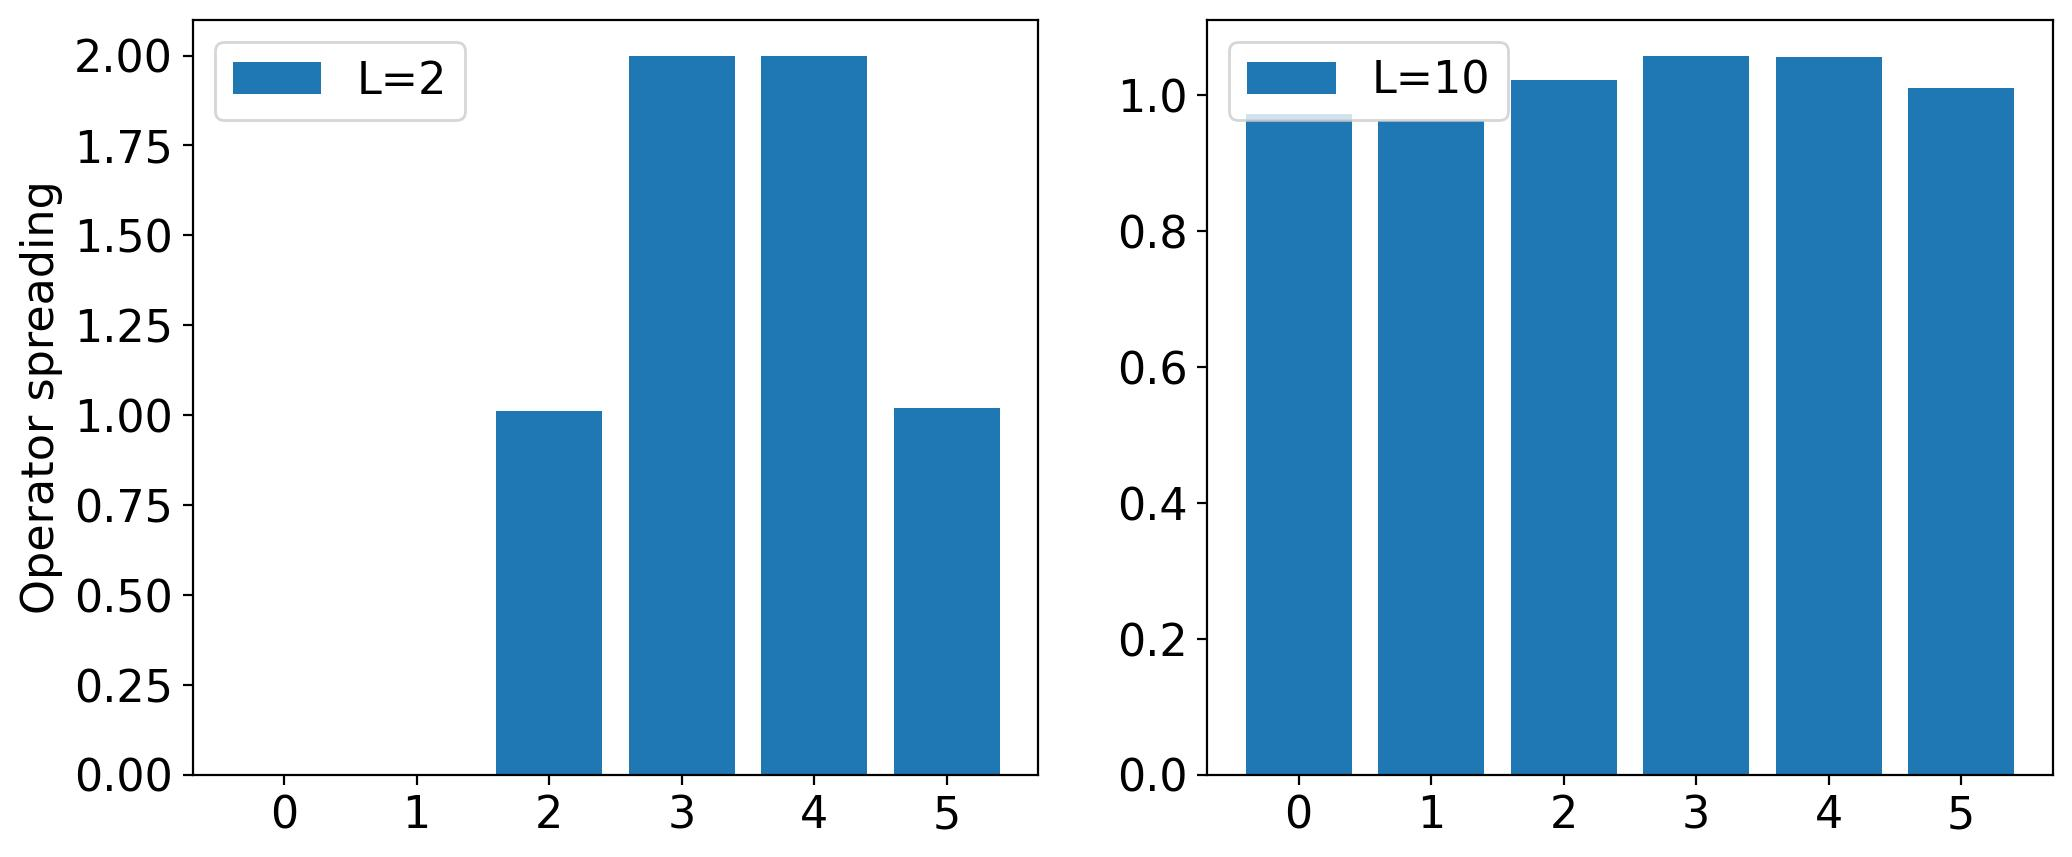

## 参考资料

[1] https://arxiv.org/pdf/2201.01452.pdf.